In [1]:
import sys, os, time
import torch
sys.path.append("../src/")

import utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import interpolate

In [2]:
ceph_dir = utils.get_ceph_dir()
mike_data_dir = os.path.join(ceph_dir, "mike_data")

In [3]:
metadata = {"diffre": {"name": "2D Diffusion-Reaction",
                       "model": "MPP-AViT-B",
                       "path": "diffre2d",
                       "fields": ["$u$", "$v$"],
                        "fps": 5,
                       "dynamic_range": True},
            "incompNS": {"name": "Incompressible Navier-Stokes",
                         "model": "MPP-AViT-B",
                         "path": "incompNS",
                         "fields": ['$v_x$', '$v_y$', '$\\rho_\\mathrm{smoke}$'],
                         "fps": 10,
                         "dynamic_range": False},
            "swe": {"name": "2D Shallow-Water",
                    "model": "MPP-AViT-B",
                    "path": "swe",
                    "fields": ['$h$'],
                     "fps": 5,
                    "dynamic_range": False},
            "turb800": {"name": "Compressible Navier-Stokes (Turb)",
                        "model": "MPP-AViT-B (Finetuned 800)",
                        "path": "turb800",
                        "fields": ['$v_x$', '$v_y$', '$\\rho$', '$p$'],
                        "fps": 6,
                        "dynamic_range": True}}

In [6]:
dataname = "turb800"
out_filename = f"mpp_{dataname}_v4_youtube.mp4"

nb_context_frames = 16

cmap = "inferno"

save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none',
         'image.cmap': cmap}
plt.rcParams.update(params)

In [7]:
data_truth = np.swapaxes(np.load(os.path.join(mike_data_dir, metadata[dataname]["path"] + "_gt.npy"))[:, 0], 0, 1)
data_pred = np.swapaxes(np.load(os.path.join(mike_data_dir, metadata[dataname]["path"] + "_pred.npy"))[:, 0], 0, 1)

fields = metadata[dataname]["fields"]
dynamic_range = metadata[dataname]["dynamic_range"]
system_name = metadata[dataname]["name"]
model_name = metadata[dataname]["model"]
fps = metadata[dataname]["fps"]
total_fps = fps # To add interpolated frames, choose a total_fps > fps (choose multiples of fps)


In [8]:
print(data_truth.shape, data_pred.shape)

(4, 21, 512, 512) (4, 216, 512, 512)


In [9]:
def loss_func_nrmse(input, target, mean_dim=None):
    x = np.sqrt(np.mean((input - target) ** 2, axis=(-1, -2)) / np.mean(target ** 2 + 1e-7, axis=(-1, -2)))
    return x.mean(axis=mean_dim)

In [10]:
def make_video_v2(recon, out_filename, fps=2, total_fps=2, nb_context_frames=16):
    nframes = recon.shape[-3]

    nSeconds = nframes // fps

    vmin = np.min(recon, axis=(-1, -2, -3))
    vmax = np.max(recon, axis=(-1, -2, -3))

    ims = [None,] * len(fields)

    i = 0
    fig, axs = plt.subplots(1, len(fields), figsize=(3*len(fields), 3), sharex=True, sharey=True)
    for j in range(len(fields)):
        ims[j] = axs[j].imshow(recon[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
    for j in range(len(fields)):
        axs[j].set_title(fields[j] + ' - Frame {}'.format(i))
    fig.tight_layout()

    def animate_func(i):
        if i % total_fps == 0:
            print( '.', end ='' )
        i_eff = i // (total_fps // fps)
        i_eff_mod = i % (total_fps // fps)
        if i_eff != nframes - 1:
            f_interp = interpolate.interp1d([0, total_fps // fps], [recon[:, i_eff, :, :], recon[:, i_eff+1, :, :]], axis=0)
            recon_interp = f_interp(i_eff_mod)
        else:
            recon_interp = recon[:, i_eff, :, :]
        for j in range(len(fields)):
            ims[j].set_array(recon_interp[j, :, :])
            suffix = '(Context)' if i_eff < nb_context_frames - 2 else '(Prediction)'
            axs[j].set_title(fields[j] + ' - Frame {} '.format(i_eff) + suffix)
        return ims

    anim = animation.FuncAnimation(
                                fig, 
                                animate_func, 
                                frames = nSeconds * total_fps,
                                interval = 1000 / total_fps, # in ms
                                )

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=total_fps, bitrate=5000)

    anim.save(f'figs/{out_filename}', writer=writer) # Need to install ffmpeg and maybe

In [11]:
def compute_power_spectrum(recon, truth):
    bins = torch.linspace(0, np.pi, 100)
    bins, ps_recon, _ = utils.power_spectrum_iso2d(torch.from_numpy(recon).unsqueeze(0), bins=bins)
    if truth is not None:
        bins, ps_truth, _ = utils.power_spectrum_iso2d(torch.from_numpy(truth).unsqueeze(0), bins=bins)
        bins, ps_diff, _ = utils.power_spectrum_iso2d(torch.from_numpy(recon - truth).unsqueeze(0), bins=bins)

    bins = bins.cpu().numpy()
    ps_recon = ps_recon.cpu().numpy()[0]
    if truth is not None:
        ps_truth = ps_truth.cpu().numpy()[0]
        ps_diff = ps_diff.cpu().numpy()[0]
    else:
        ps_truth = np.empty_like(ps_recon)
        ps_truth[:] = np.nan
        ps_diff = np.empty_like(ps_recon)
        ps_diff[:] = np.nan

    bins_centers = 0.5 * (bins[1:] + bins[:-1])


    if ps_truth.ndim == 1:
        ps_truth = ps_truth[np.newaxis, np.newaxis, :]
        ps_recon = ps_recon[np.newaxis, np.newaxis, :]
        ps_diff = ps_diff[np.newaxis, np.newaxis, :]
        
    return bins_centers, ps_truth[:, :, :-1], ps_recon[:, :, :-1], ps_diff[:, :, :-1]


def make_video_v4(recon,
                  truth,
                  out_filename,
                  fields_labels=None,
                  fps=2,
                  total_fps=2,
                  nb_context_frames=16,
                  dynamic_range=False,
                  system_name=None,
                  model_name=None):
    
    if fields_labels is None:
        fields_labels = fields

    nframes = recon.shape[-3]
    nframes_truth = truth.shape[-3]

    nSeconds = nframes // fps

    vmin = np.min(recon, axis=(-1, -2, -3))
    vmax = np.max(recon, axis=(-1, -2, -3))

    ims = []
    for i in range(2):
        ims.append([None,] * len(fields))
    lines = [None, None] * len(fields)

    i = 0
    
    bins, ps_truth, ps_recon, ps_diff = compute_power_spectrum(recon[:, i], truth[:, i])

    fig, axs = plt.subplots(3, len(fields), figsize=(3*len(fields) if len(fields) > 1 else 3, 9), layout='constrained')
    axs = axs.reshape(3, len(fields))
    for j in range(len(fields)):
        ims[0][j] = axs[0, j].imshow(recon[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
        ims[1][j] = axs[1, j].imshow(truth[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
        lines[2*j] = axs[2, j].plot(bins, ps_truth[j, j], label='Ground truth')[0]
        lines[2*j+1] = axs[2, j].plot(bins, ps_recon[j, j], label='Prediction')[0]
    for j in range(len(fields)):
        axs[0, j].set_title(fields_labels[j])
    axs[0, 0].set_ylabel('Prediction')
    axs[1, 0].set_ylabel('Ground truth')
    axs[2, 0].set_ylabel('Power spectrum')
    for j in range(len(fields)):
        axs[2, j].set_yscale('log')
        axs[2, j].set_xscale('log')
        axs[2, j].set_xlabel('$k$')
        axs[2, j].set_ylim([1e-3, 1e8])
    axs[2, 0].legend(loc='upper right')
    fig.suptitle(f"{system_name} \nModel: {model_name}\nTimestep 0 (Context)\n")
    # Remote tick labels
    for i in range(3):
        for j in range(len(fields)):
            if j != 0:
                # Remove y tick labels
                axs[i, j].set_yticklabels([])
            if i == 0:
                # Remove x tick labels
                axs[i, j].set_xticklabels([])
    fig.subplots_adjust(wspace=0.15, hspace=0.15)

    def animate_func(i):
        if i % total_fps == 0:
            print( '.', end ='' )
        i_eff = i // (total_fps // fps)
        i_eff_mod = i % (total_fps // fps)
        if i_eff != nframes - 1:
            f_rec_interp = interpolate.interp1d([0, total_fps // fps], [recon[:, i_eff, :, :], recon[:, i_eff+1, :, :]], axis=0)
            recon_interp = f_rec_interp(i_eff_mod)
        else:
            recon_interp = recon[:, i_eff, :, :]
        if i_eff < nframes_truth - 1:
            f_tru_interp = interpolate.interp1d([0, total_fps // fps], [truth[:, i_eff, :, :], truth[:, i_eff+1, :, :]], axis=0)
            truth_interp = f_tru_interp(i_eff_mod)
        elif i_eff == nframes_truth - 1:
            truth_interp = truth[:, -1, :, :]
        else:
            truth_interp = np.empty_like(truth[:, -1, :, :])
            truth_interp[:] = np.nan
        if i_eff_mod == 0:
            bins, ps_truth, ps_recon, ps_diff = compute_power_spectrum(recon[:, i_eff], truth[:, i_eff] if i_eff < nframes_truth else None)
            for j in range(len(fields)):
                lines[2*j].set_ydata(ps_truth[j, j])
                lines[2*j+1].set_ydata(ps_recon[j, j])
        nrmse = None
        if i_eff >= nb_context_frames - 2 and i_eff < nframes_truth:
            nrmse = loss_func_nrmse(recon[:, i_eff, :, :], truth[:, i_eff, :, :])
            suffix = '(Prediction)'
        elif i_eff >= nframes_truth:
            nrmse = np.nan
            suffix = '(Prediction)'
            # Remove first element of legend
            handles, labels = axs[2, 0].get_legend_handles_labels()
            handles = [handles[1]]
            labels = [labels[1]]
            axs[2, 0].legend(handles, labels, loc='upper right')
        else:
            suffix = '(Context)'
        for j in range(len(fields)):
            ims[0][j].set_array(recon_interp[j, :, :])
            ims[1][j].set_array(truth_interp[j, :, :])

            if dynamic_range:
                vmin = np.percentile(recon_interp[j, :, :], 1)
                vmax = np.percentile(recon_interp[j, :, :], 99)
                ims[0][j].set_clim(vmin, vmax)
                ims[1][j].set_clim(vmin, vmax)

        title = f"{system_name}\nModel: {model_name}\nTimestep {i_eff} {suffix}\n"
        if nrmse is not None:
            if nrmse is not np.nan:
                title += f"NRMSE = {nrmse:.3f}"
            else:
                title += f"NRMSE = N/A"
        fig.suptitle(title, fontsize=16)

        return ims, lines

    anim = animation.FuncAnimation(
                                fig,
                                animate_func, 
                                frames = nSeconds * total_fps,
                                interval = 1000 / total_fps, # in ms
                                )

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=total_fps, bitrate=5000)

    anim.save(f'figs/{out_filename}', writer=writer) # Need to install ffmpeg and maybe

/tmp/ipykernel_154785/1416513625.py:74: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[2, j].set_yscale('log')
/tmp/ipykernel_154785/1416513625.py:89: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.15, hspace=0.15)


......................................

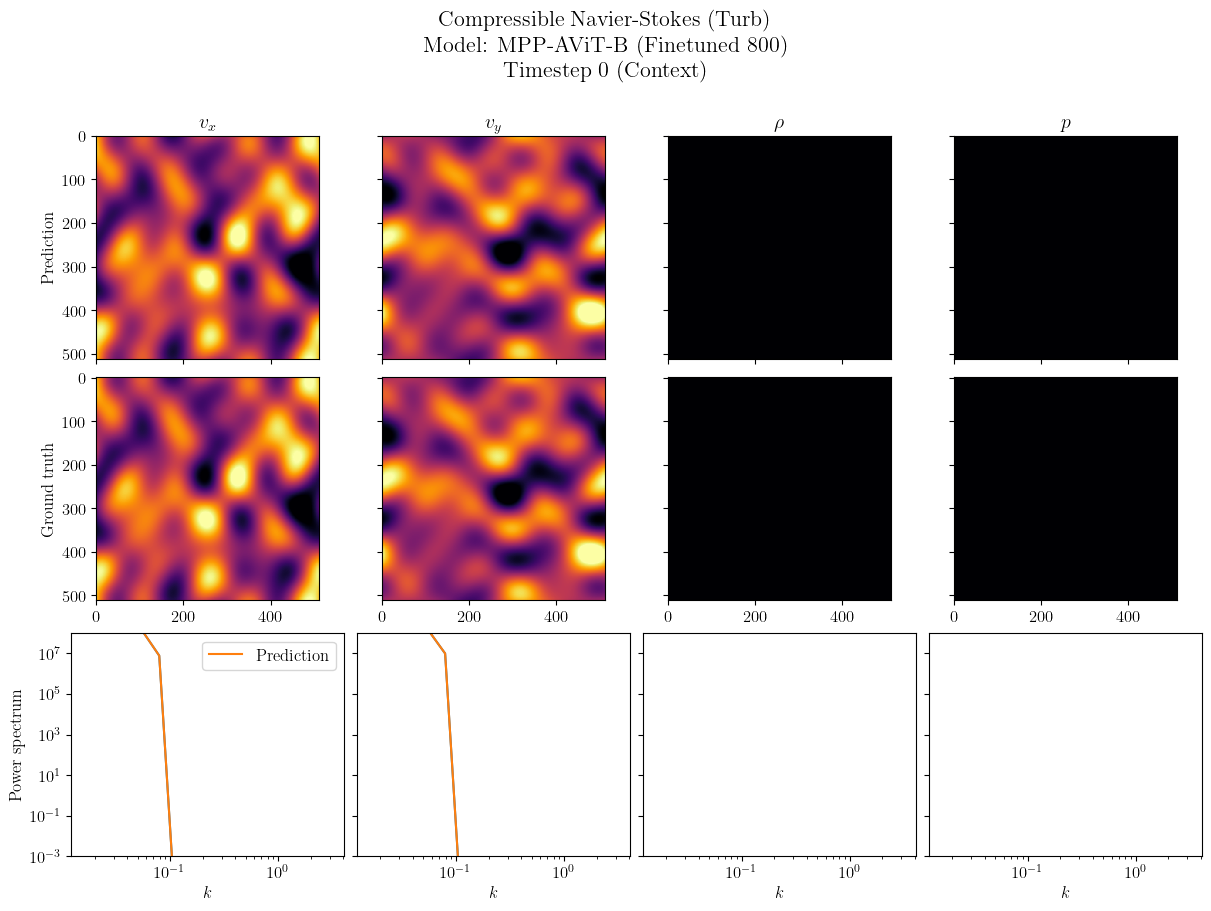

In [12]:
#make_video_v2(data_pred, out_filename)

make_video_v4(data_pred,
              data_truth,
              out_filename,
              fields_labels=fields,
              fps=fps,
              total_fps=total_fps,
              nb_context_frames=nb_context_frames,
              system_name=system_name,
              model_name=model_name,
              dynamic_range=dynamic_range)